In [23]:
import pandas as pd
#from tqdm._tqdm_notebook import tqdm_notebook
#tqdm_notebook.pandas()

import timeit

import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

from collections import Counter

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, label_binarize
import sklearn as sk
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, plot_roc_curve

from itertools import combinations
import random, joblib

- **feat_cols** - признаки для обучения
- **target_cols** - целевые признаки

In [2]:
feat_cols = ['freq', 'query_results_count_num', 'len_mt', 'len_md', 'len_kw', 'len_w_mt', 'len_w_md', 'len_w_kw', 'words_count', 'words_count_sw', 'spamity', 'max_spam', 'water_content', 'tf_idf', 'density']
target_cols = ['pos', 'real_pos', 'page', 'is_first_page']
df = pd.read_csv('df_to_model_source.csv', sep=';') # df_to_model_source df_to_model
df.head()

,domain,url,freq,query_results_count_num,pos,real_pos,is_first_page,page,search_query_n,len_mt,...,len_w_mt,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density
0,novosibirsk.berfi.ru,http://novosibirsk.berfi.ru/kirpich-bloki/stro...,98,5000000,0.0,0.0,1,0,керамзитобетонный блок в название_город,88,...,12,24,0,1492,1136,0.061837,70,0.241287,0.071440,0.058304
1,www.kora-trading.ru,http://www.kora-trading.ru/novosibirsk/keramzi...,98,5000000,1.0,1.0,1,0,керамзитобетонный блок в название_город,84,...,12,25,10,1233,1010,0.018812,19,0.180860,0.020017,0.016337
2,nsk.pulscen.ru,https://nsk.pulscen.ru/price/100303-bloki-stro...,98,5000000,2.0,2.0,1,0,керамзитобетонный блок в название_город,72,...,10,27,2,1517,1340,0.030597,41,0.116678,0.019660,0.016045
3,penoblok-gazobeton.ru,http://penoblok-gazobeton.ru/novosibirsk/keram...,98,5000000,3.0,3.0,1,0,керамзитобетонный блок в название_город,73,...,8,15,5,1040,984,0.052846,52,0.053846,0.056658,0.046240
4,www.avito.ru,https://www.avito.ru/novosibirsk?q=%D0%BA%D0%B...,98,5000000,4.0,4.0,1,0,керамзитобетонный блок в название_город,112,...,18,59,0,1655,1484,0.038540,57,0.106344,0.024854,0.020284


In [3]:
df.sort_values(by='page')

,domain,url,freq,query_results_count_num,pos,real_pos,is_first_page,page,search_query_n,len_mt,...,len_w_mt,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density
0,novosibirsk.berfi.ru,http://novosibirsk.berfi.ru/kirpich-bloki/stro...,98,5000000,0.0,0.0,1,0,керамзитобетонный блок в название_город,88,...,12,24,0,1492,1136,0.061837,70,0.241287,0.071440,0.058304
17843,beton-stavropol.ru,https://beton-stavropol.ru/,217,9000000,3.0,3.0,1,0,купить бетон название_город,110,...,19,23,0,1970,1675,0.040072,67,0.151269,0.017308,0.015251
17844,www.avito.ru,https://www.avito.ru/stavropol?q=%D0%B1%D0%B5%...,217,9000000,4.0,4.0,1,0,купить бетон название_город,95,...,17,59,0,2029,1742,0.031268,54,0.148842,0.018728,0.016503
17845,stavropol.zoon.ru,https://stavropol.zoon.ru/building/type/beton_...,217,9000000,6.0,5.0,1,0,купить бетон название_город,73,...,14,49,3,1079,900,0.057778,52,0.165894,0.034046,0.030000
17846,stavropol.flagma.ru,https://stavropol.flagma.ru/beton-so218455-1.html,217,9000000,7.0,6.0,1,0,купить бетон название_город,60,...,10,49,0,2352,2086,0.058034,121,0.113520,0.041367,0.036451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,legengrad.ru,https://legengrad.ru/doma/premium-doma/komplek...,330,7000000,49.0,87.0,0,4,бетон с доставка название_город,75,...,9,16,0,2349,1761,0.033561,59,0.251596,0.163218,0.152446
6470,tyumen-beton.ru,https://tyumen-beton.ru/keramzitobeton/,330,7000000,51.0,89.0,0,4,бетон с доставка название_город,114,...,20,26,0,1901,1594,0.038969,62,0.163072,0.144235,0.134716
17931,stavropol.zacenoy.ru,https://stavropol.zacenoy.ru/product/keramzito...,9,12000000,54.0,93.0,0,4,купить керамзитобетонный блок в название_город,46,...,5,11,3,543,438,0.054422,24,0.187845,0.022033,0.016629
17964,stavropol.40nog.ru,https://stavropol.40nog.ru/keramzitobetonnye-b...,74,13000000,42.0,81.0,0,4,купить керамзитоблок название_город,93,...,13,33,5,3822,3238,0.058624,190,0.152015,0.001392,0.000926


## Нормализация данных

In [4]:
scaler = StandardScaler()
scaler.fit(df[feat_cols])
df_std = df.copy()
df_std[feat_cols] = scaler.transform(df[feat_cols])

In [5]:
# scaler=joblib.load('std_scaler.bin')
joblib.dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

### Подбор весов
Для модели KNN признаки должны быть стандартизированы, но некоторые стоит увеличить, чтобы придать им вес (значимость по сравнение с другими признаками)

In [6]:
# df_std['water_content'] = df_std['water_content'] * 1.25
# веса подобранны вручную. Изменение TF-IDF, density, spamity - не дало результата

### Добавить признак вычисленный KNN

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(df_std[feat_cols], df_std['is_first_page'], test_size=0.2, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=11, weights='uniform')
#neigh.fit(X_train, y_train)
#y_pred = neigh.predict(X_test)
#f1_score(y_test, y_pred)
neigh.fit(df_std[feat_cols], df_std['is_first_page'])
knn_f = np.around(neigh.predict_proba(df_std[feat_cols]), decimals=2)
knn_f[:5, 0]

array([0.36, 0.73, 0.  , 0.64, 0.  ])

### Запишем предсказанные значения модели KNN как признак

In [8]:
df_std['knn_distance'] = knn_f[:, 0]
df['knn_distance'] = knn_f[:, 0]
df_std.head()

,domain,url,freq,query_results_count_num,pos,real_pos,is_first_page,page,search_query_n,len_mt,...,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density,knn_distance
0,novosibirsk.berfi.ru,http://novosibirsk.berfi.ru/kirpich-bloki/stro...,0.007107,-0.574822,0.0,0.0,1,0,керамзитобетонный блок в название_город,0.312425,...,-0.028209,-0.383218,-0.104986,-0.230734,0.270327,-0.103525,2.040927,0.818497,0.718848,0.36
1,www.kora-trading.ru,http://www.kora-trading.ru/novosibirsk/keramzi...,0.007107,-0.574822,1.0,1.0,1,0,керамзитобетонный блок в название_город,0.177058,...,0.022807,0.632580,-0.297243,-0.333090,-1.631787,-0.663807,0.818912,-0.408222,-0.390014,0.73
2,nsk.pulscen.ru,https://nsk.pulscen.ru/price/100303-bloki-stro...,0.007107,-0.574822,2.0,2.0,1,0,керамзитобетонный блок в название_город,-0.229042,...,0.124839,-0.180059,-0.086428,-0.065014,-1.110779,-0.422117,-0.479038,-0.416753,-0.397725,0.00
3,penoblok-gazobeton.ru,http://penoblok-gazobeton.ru/novosibirsk/keram...,0.007107,-0.574822,3.0,3.0,1,0,керамзитобетонный блок в название_город,-0.195201,...,-0.487351,0.124681,-0.440509,-0.354211,-0.127196,-0.301272,-1.749675,0.465860,0.400091,0.64
4,www.avito.ru,https://www.avito.ru/novosibirsk?q=%D0%BA%D0%B...,0.007107,-0.574822,4.0,4.0,1,0,керамзитобетонный блок в название_город,1.124625,...,1.757347,-0.383218,0.016010,0.051964,-0.759648,-0.246342,-0.688006,-0.292840,-0.285717,0.00


Сохраним новый признак в списке признаков обучения

In [9]:
feat_cols = feat_cols + ['knn_distance']
feat_cols

['freq',
 'query_results_count_num',
 'len_mt',
 'len_md',
 'len_kw',
 'len_w_mt',
 'len_w_md',
 'len_w_kw',
 'words_count',
 'words_count_sw',
 'spamity',
 'max_spam',
 'water_content',
 'tf_idf',
 'density',
 'knn_distance']

##  Точечные распределения признаков

Wall time: 24.6 s


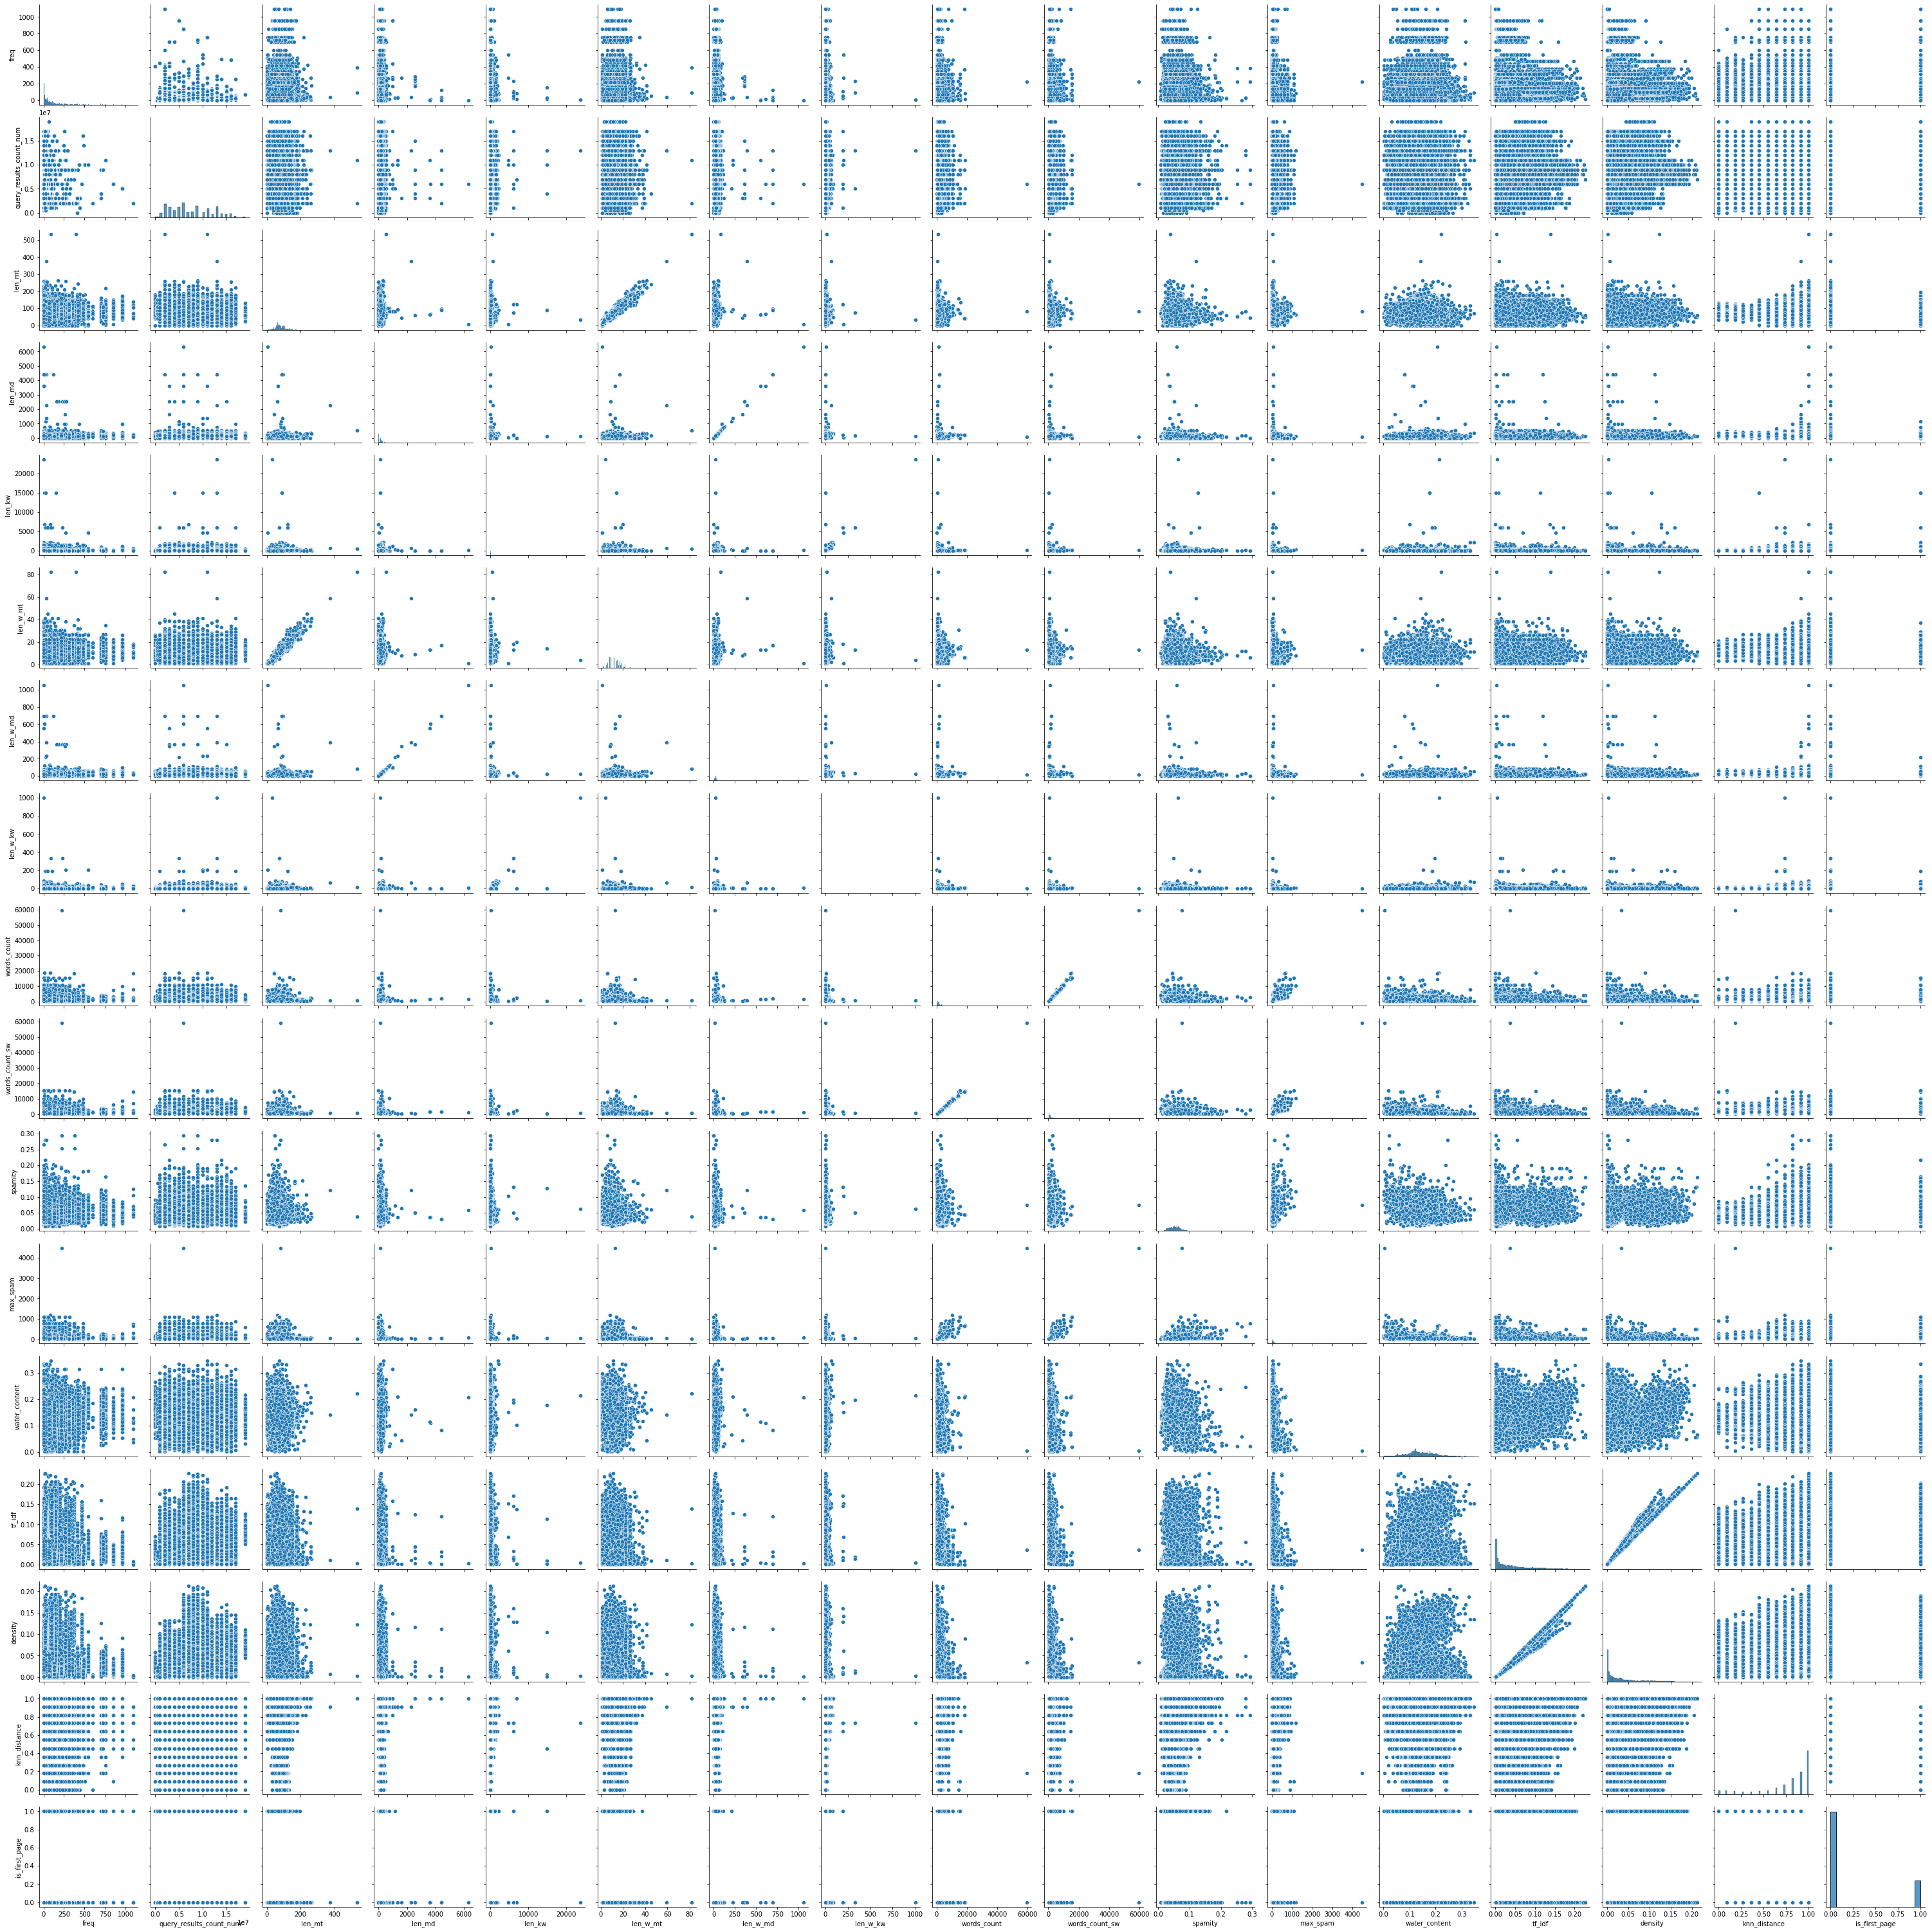

In [10]:
%%time
sns.pairplot(df[feat_cols + ['is_first_page']]) # target_cols = ['pos', 'real_pos', 'page', 'is_first_page']

<AxesSubplot:>

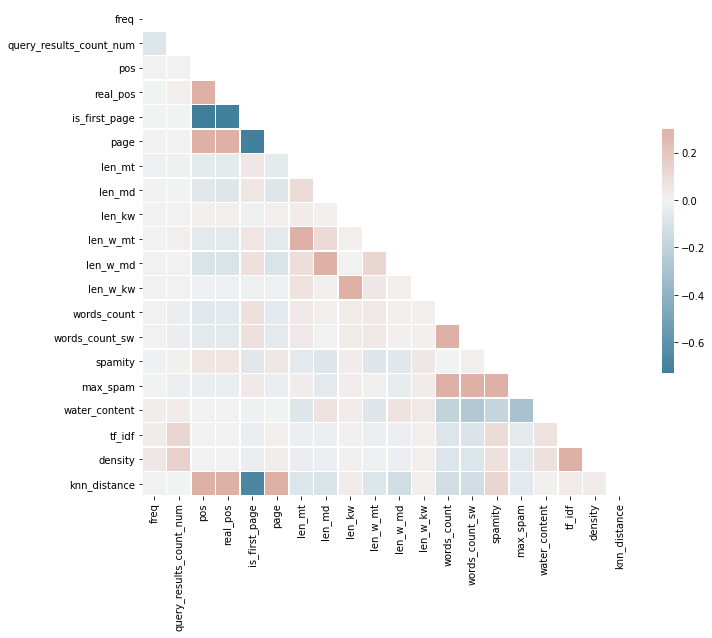

In [11]:
#method{‘pearson’, ‘kendall’, ‘spearman’} 
df_corr = df.corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Распределение значений 
- гистограммы
- ящики с усами

In [12]:
df.describe()

,freq,query_results_count_num,pos,real_pos,is_first_page,page,len_mt,len_md,len_kw,len_w_mt,len_w_md,len_w_kw,words_count,words_count_sw,spamity,max_spam,water_content,tf_idf,density,knn_distance
count,24057.000000,2.405700e+04,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.00000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000,24057.000000
mean,97.006443,7.505718e+06,26.230744,43.863823,0.214324,1.943634,78.768051,152.167976,79.817267,11.88652,24.552937,3.772582,1633.431517,1420.032257,0.055723,79.423453,0.140365,0.037129,0.031098,0.779912
std,139.804206,4.359214e+06,15.231560,28.753660,0.410361,1.418990,29.549972,121.689673,298.073797,4.87118,19.602150,9.844680,1347.178544,1231.020491,0.022620,91.027509,0.049450,0.041920,0.037848,0.281333
min,0.000000,9.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000,300.000000,215.000000,0.007262,5.000000,0.001049,0.000046,0.000033,0.000000
25%,13.000000,4.000000e+06,14.000000,21.000000,0.000000,1.000000,61.000000,105.000000,0.000000,9.00000,16.000000,0.000000,810.000000,685.000000,0.040044,34.000000,0.109320,0.003713,0.002630,0.730000
50%,47.000000,7.000000e+06,26.000000,44.000000,0.000000,2.000000,76.000000,144.000000,30.000000,11.00000,23.000000,1.000000,1340.000000,1171.000000,0.053640,58.000000,0.136119,0.020623,0.015786,0.910000
75%,120.000000,1.100000e+07,39.000000,67.000000,0.000000,3.000000,96.000000,188.000000,109.000000,15.00000,31.000000,5.000000,1890.000000,1626.000000,0.066421,95.000000,0.176030,0.056658,0.045035,1.000000
max,1096.000000,1.900000e+07,55.000000,93.000000,1.000000,4.000000,534.000000,6313.000000,23644.000000,82.00000,1057.000000,1002.000000,59558.000000,59310.000000,0.293781,4483.000000,0.345811,0.227110,0.212121,1.000000


Рассмотрим spamity, water_content, tf_idf, density

In [13]:
cols_to_analyze = ['spamity', 'water_content', 'tf_idf', 'density']

Посмотрим графики для данных на первой странице

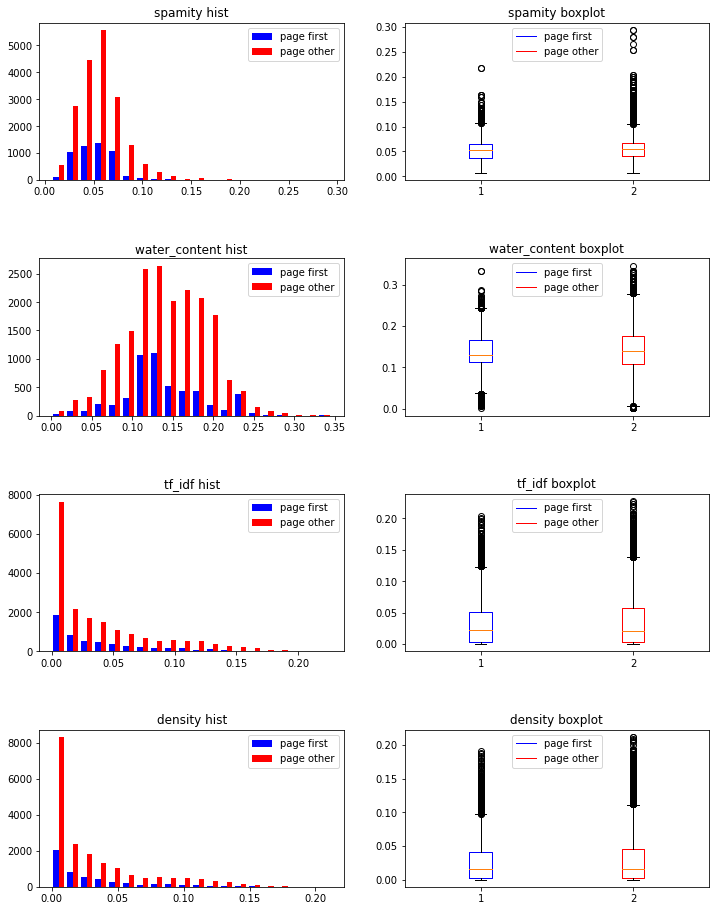

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
n_bins = 20

# y-offset
plt.subplots_adjust(top=1, bottom=0, hspace=.5)

for i in range(len(cols_to_analyze)):
    col = cols_to_analyze[i]
    colors = ['blue', 'red']
    axs[i, 0].hist(
        [df[df['page'] == 0][col], df[df['page'] != 0][col]], 
        bins=n_bins, 
        label=['page first', 'page other'], 
        color=colors
    )
    axs[i, 0].legend(prop={'size': 10})
    axs[i, 0].set_title(col + ' hist')
    
    bp = axs[i, 1].boxplot([df[df['page'] == 0][col], df[df['page'] != 0][col]])
    # set boxplot color
    for patch, color in zip(bp['boxes'], colors):
        patch.set_color(color)
    axs[i, 1].legend(bp["boxes"], ["page first", "page other"], loc='upper center')
    axs[i, 1].set_title(col + ' boxplot')


Спамность и водность первых страниц имеют отличные от других страниц распрепределения

### Запишем границы рекомендуемых значений

In [15]:
borders = {}
borders = {col:[df[col].describe()['25%'], df[col].describe()['75%']] for col in cols_to_analyze}
borders

{'spamity': [0.040043684018929736, 0.06642066420664207],
 'water_content': [0.1093200468933177, 0.1760299625468165],
 'tf_idf': [0.003712642158159217, 0.05665760749627041],
 'density': [0.0026298487836949377, 0.04503464203233257]}

# Для всех запросов

## Классификация бинарная

<AxesSubplot:>

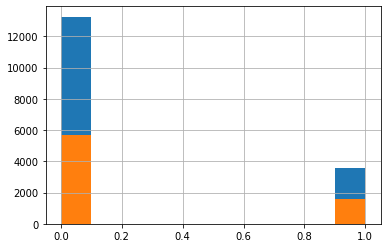

In [20]:
# исходные значения
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df['is_first_page'], test_size=0.3, random_state=42)
# стандартизированные значения
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(df_std[feat_cols], df_std['is_first_page'], test_size=0.3, random_state=42)

y_train.hist()
y_test.hist()

Увеличим выборку для единиц

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

Баланс классов
0    13250
1    10767
Name: is_first_page, dtype: int64


<AxesSubplot:>

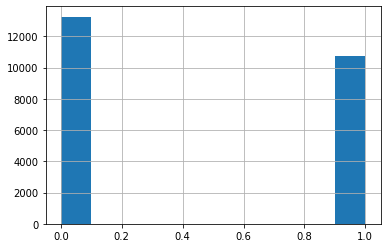

In [22]:
up_features_train, up_target_train = upsample(X_train, y_train, 3)
up_features_train_std, up_target_train_std = upsample(X_train_std, y_train_std, 3)
print('Баланс классов')
print(up_target_train.value_counts())
up_target_train.hist()

### GradientBoostingClassifier

In [23]:
%%time
"""
"""
parametrs = { 
    'n_estimators': range (100, 151, 200),
    'max_depth': range (5,16, 18),
    'learning_rate': [0.1, 0.5, 0.7],
    'random_state': [42]
}

GBC = GradientBoostingClassifier()
grid = GridSearchCV(GBC, parametrs, cv=5)
#grid.fit(X_train, y_train)
grid.fit(up_features_train, up_target_train)

#GBC.fit(X_train, y_train)
#pred_GBC = GBC.predict(X_test)
#roc_auc_score(y_test, pred_GBC)
grid.best_params_

Wall time: 1min 47s


{'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 100, 'random_state': 42}

In [26]:
%%time
GBC = GradientBoostingClassifier(
    learning_rate=0.7, 
    max_depth=5,
    n_estimators= 100,
    random_state = 42
)
#GBC.fit(X_train, y_train)
GBC.fit(up_features_train, up_target_train)

pred_GBC = GBC.predict(X_test)
print(roc_auc_score(y_test, pred_GBC))
print(f1_score(y_test, pred_GBC))

0.8518441371243316
0.7518979653811115
Wall time: 8.17 s


In [25]:
GBC.predict_proba(X_test)

array([[2.32257286e-02, 9.76774271e-01],
       [9.14815556e-01, 8.51844437e-02],
       [2.51178605e-03, 9.97488214e-01],
       ...,
       [2.83148208e-02, 9.71685179e-01],
       [9.99881625e-01, 1.18374773e-04],
       [2.50144804e-03, 9.97498552e-01]])

### RandomForestClassifier

In [26]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               #'class_weight': ['balanced'],
             }
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
#rs.fit(X_train, y_train)
rs.fit(up_features_train, up_target_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 4min 16s


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [27]:
"""
{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}
"""

"\n{'n_estimators': 700,\n 'min_samples_split': 12,\n 'min_samples_leaf': 2,\n 'max_features': 'sqrt',\n 'max_depth': 13,\n 'bootstrap': False}\n"

In [27]:
%%time
RF = RandomForestClassifier(
    n_estimators=600, 
    max_depth=15, 
    random_state=42, 
    min_samples_split=23,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False
)
#RF.fit(X_train, y_train)
RF.fit(up_features_train, up_target_train)
pred_rf = RF.predict(X_test)
#round(RF.score(X_test,y_test), 4) up_features_train, up_target_train
print('origin data roc:',roc_auc_score(y_test, pred_rf))
print('origin data f1:',f1_score(y_test, pred_rf))

RF_std = RandomForestClassifier(
    n_estimators=700, 
    max_depth=13, 
    random_state=42, 
    min_samples_split=12,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False
)
#RF_std.fit(X_train_std, y_train_std)
RF_std.fit(up_features_train_std, up_target_train_std)
pred_rf = RF_std.predict(X_test_std)
#round(RF.score(X_test,y_test), 4)
print('scalered data roc:',roc_auc_score(y_test_std, pred_rf))
print('scalered data f1:',f1_score(y_test_std, pred_rf))

origin data roc: 0.8442719051594687
origin data f1: 0.7451463790446843
scalered data roc: 0.8457467586255494
scalered data f1: 0.744129307715767
Wall time: 1min


### MLPClassifier

In [28]:
%%time
NN = MLPClassifier(
    solver='adam', 
    alpha=1e-5, 
    hidden_layer_sizes=(9, 4), 
    random_state=42, 
    activation='tanh',
    learning_rate='adaptive',
    n_iter_no_change=500,
    max_iter=10000
) #relu
#NN.fit(X_train_std, y_train_std)
NN.fit(up_features_train_std, up_target_train_std)
pred_nn = NN.predict(X_test_std)
#round(NN.score(X_test,y_test), 4)
print('roc',roc_auc_score(y_test_std, pred_nn))
print('f1',f1_score(y_test_std, pred_nn))

roc 0.8226490965619088
f1 0.6719325961032123
Wall time: 1min 36s


### Catboost

In [30]:
%%time
cat = CatBoostClassifier(loss_function='Logloss', verbose=False)
grid = {
    'learning_rate': [0.05, 0.1, 0.25, .5],
    'depth': [5, 10, 16],
    'iterations': [15, 30, 50]
}

# up_features_train, up_target_train
# X_train y_train

grid_search_result = cat.grid_search(grid, X=up_features_train, cv=4, y=up_target_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4199846953
bestIteration = 14


bestTest = 0.3811662849
bestIteration = 14


bestTest = 0.3577170674
bestIteration = 14


bestTest = 0.3437512345
bestIteration = 14


bestTest = 0.3782687557
bestIteration = 29


bestTest = 0.3589901935
bestIteration = 29


bestTest = 0.3431083986
bestIteration = 29


bestTest = 0.3227384311
bestIteration = 29


bestTest = 0.3650542946
bestIteration = 49


bestTest = 0.3502745343
bestIteration = 49


bestTest = 0.3259421795
bestIteration = 49


bestTest = 0.2997617912
bestIteration = 49


bestTest = 0.4077653697
bestIteration = 14


bestTest = 0.3587242526
bestIteration = 14


bestTest = 0.3170482844
bestIteration = 14


bestTest = 0.2858621143
bestIteration = 14


bestTest = 0.3594363602
bestIteration = 29


bestTest = 0.3226113511
bestIteration = 29


bestTest = 0.2807458977
bestIteration = 29


bestTest = 0.241776325
bestIteration = 29


bestTest = 0.3292380442
bestIteration = 49


bestTest = 0.2930500011
bestIteration = 49


bestTest =

In [37]:
cat._init_params

{'loss_function': 'Logloss',
 'verbose': False,
 'depth': 16,
 'iterations': 50,
 'learning_rate': 0.5}

In [24]:
%%time
CB = CatBoostClassifier(
    iterations=50, 
    depth=16,
    learning_rate=.5,
    loss_function='Logloss',
    verbose=False
)

# CB.fit(X_train, y_train)
CB.fit(up_features_train, up_target_train)
preds_cb = CB.predict(X_test)
print('roc_auc_score:', roc_auc_score(y_test, preds_cb))
print('f1:', f1_score(y_test, preds_cb))

roc_auc_score: 0.8139299006438876
f1: 0.7029053420805997
Wall time: 56.4 s


## SVC

In [59]:
%%time
"""
parameters = {
    'kernel':('linear', 'rbf'), 
    'C':[1, 5, 10],
    'gamma':[.5, .1, .05, .005, .005]
}
SVM = svm.SVC()
clf = GridSearchCV(SVM, parameters)
clf.fit(up_features_train_std, up_target_train_std)
clf.best_estimator_
"""

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10],
                         'gamma': [0.5, 0.1, 0.05, 0.005, 0.005],
                         'kernel': ('linear', 'rbf')})

In [29]:
%%time
SVM = SVC(C=5, gamma=.005, probability=True)
SVM.fit(up_features_train_std, up_target_train_std)
pred_svm = SVM.predict(X_test_std)
print('roc',roc_auc_score(y_test_std, pred_svm))
print('f1',f1_score(y_test_std, pred_svm))

roc 0.8157509381298971
f1 0.6964393482196741
Wall time: 1min 7s


In [72]:
SVM.predict_proba(X_test_std)

array([[0.17023768, 0.82976232],
       [0.57254684, 0.42745316],
       [0.01568665, 0.98431335],
       ...,
       [0.08700023, 0.91299977],
       [0.90338865, 0.09661135],
       [0.01192086, 0.98807914]])

### Модель со случайным выбором

In [73]:
pred_random = [random.randint(0, 1) for i in range(len(y_test))]
roc_auc_score(y_test, pred_random)

0.4978203562979462

## Диагностика моделей

### Сравним качество отдельных и совместных предсказаний

In [31]:
# RandomForest + GradientBoosting + MLPClassifier + CatBoost + SVM
binary_models = [
    {'name':'GradientBoosting', 'model':GBC, 'pred':GBC.predict(X_test), 'proba':GBC.predict_proba(X_test)},
    {'name':'RandomForest', 'model':RF, 'pred':RF.predict(X_test), 'proba':RF.predict_proba(X_test)},
    {'name':'CatBoost', 'model':CB, 'pred':CB.predict(X_test), 'proba':CB.predict_proba(X_test)},
    {'name':'MLPClassifier', 'model':NN, 'pred':NN.predict(X_test_std), 'proba':NN.predict_proba(X_test_std)},
    {'name':'SVM', 'model':SVM, 'pred':SVM.predict(X_test_std), 'proba':SVM.predict_proba(X_test_std)},
]


### График roc-curve

GradientBoosting


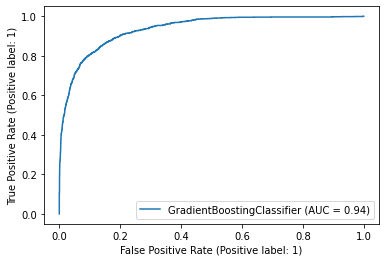

RandomForest


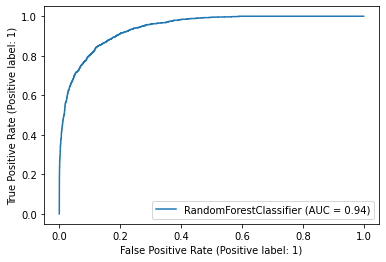

CatBoost


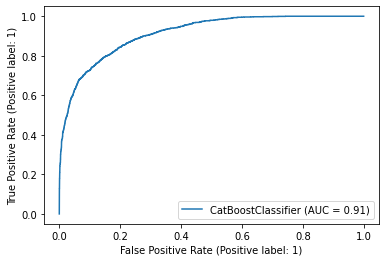

MLPClassifier


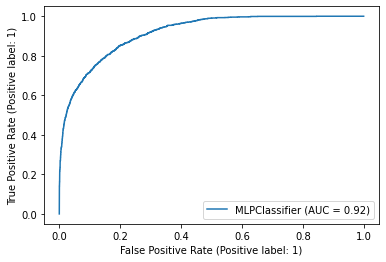

SVC


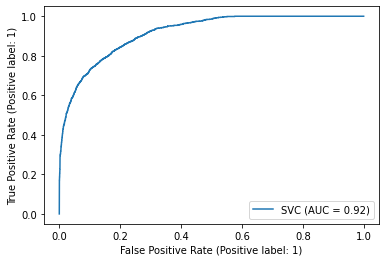

In [34]:
for row in binary_models:
    print(row['name'])
    if row['name'] == 'MLPClassifier' or row['name'] == 'SVM':
        plot_roc_curve(row['model'], X_test_std, y_test)         
    else:
        plot_roc_curve(row['model'], X_test, y_test) 
    plt.show()

### Числа

In [76]:
best_names = ''
best_roc = 0
best_f1 = 0

for k_models in range(1, len(binary_models)+1):
    comb = combinations(binary_models, k_models)
    print('Количество моеделей:',k_models)
    for row in list(comb):
        names = ''
        predict_list = list()
        proba_list = list()

        for model in row:
            names += model['name'] + ' '
            predict_list.append(model['pred'])
            proba_list.append(model['proba'])

        predict_list = np.array(predict_list).T
        result_pred = list(map(lambda val: np.int32(np.mean(val) >= .5), predict_list))
        pred_roc = roc_auc_score(y_test, result_pred)
        pred_f1 = f1_score(y_test, result_pred)
        
        proba_list = np.array(proba_list).transpose((1,0,2))
        result_proba = list(map(lambda val: np.int32(sum(val[:,0]) <= sum(val[:,1])), proba_list))
        proba_roc = roc_auc_score(y_test, result_proba)
        proba_f1 = f1_score(y_test, result_proba)
        
        # if proba_f1 > best_f1:
        if proba_f1 > best_f1:
            best_names = names
            best_f1 = proba_f1
            best_roc = proba_roc
        
        print(names)
        print()
        print('pred roc_auc:\t', pred_roc)
        print('pred f1:\t', pred_f1)
        print()
        print('proba roc_auc:\t', proba_roc)
        print('proba f1:\t', proba_f1)
        print()
        print('----------------')
        print()

Количество моеделей: 1
GradientBoosting 

pred roc_auc:	 0.8518441371243316
pred f1:	 0.7518979653811115

proba roc_auc:	 0.8518441371243316
proba f1:	 0.7518979653811115

----------------

RandomForest 

pred roc_auc:	 0.8442719051594687
pred f1:	 0.7451463790446843

proba roc_auc:	 0.8442719051594687
proba f1:	 0.7451463790446843

----------------

CatBoost 

pred roc_auc:	 0.8139299006438876
pred f1:	 0.7029053420805997

proba roc_auc:	 0.8139299006438876
proba f1:	 0.7029053420805997

----------------

MLPClassifier 

pred roc_auc:	 0.8226490965619088
pred f1:	 0.6719325961032123

proba roc_auc:	 0.8226490965619088
proba f1:	 0.6719325961032123

----------------

SVC 

pred roc_auc:	 0.8157509381298971
pred f1:	 0.6964393482196741

proba roc_auc:	 0.8161452299275097
proba f1:	 0.6941211578633244

----------------

Количество моеделей: 2
GradientBoosting RandomForest 

pred roc_auc:	 0.861511146605968
pred f1:	 0.7448863636363636

proba roc_auc:	 0.853257049003418
proba f1:	 0.75783

лучшая комбинация:

In [79]:
print(best_names)
print('f1:\t', best_f1)
print('roc:\t', best_roc)

GradientBoosting RandomForest SVC 
f1:	 0.7583025830258303
roc:	 0.8534340088335366


**Вывод**: будем использовать три модели: Случайный лес, Градиентный бустинг и Опорные вектора

## мультикласс

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[feat_cols], df['page'], test_size=0.3, random_state=42)
y_train.hist()
y_test.hist()

In [ ]:
labels = [0, 1, 2, 3, 4]
y_test = label_binarize(y_test, classes=labels)

In [ ]:
%%time
GBC = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.5, 
    max_depth=20, 
    random_state=42
)
GBC.fit(X_train, y_train)
pred_GBC = GBC.predict(X_test)
pred_GBC = label_binarize(pred_GBC, classes=labels)
roc_auc_score(y_test, pred_GBC, average='macro', multi_class='ovo')

In [ ]:
RF = RandomForestClassifier(n_estimators=600, max_depth=15, random_state=42)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
pred_rf = label_binarize(pred_rf, classes=labels)
roc_auc_score(y_test, pred_rf,average='macro', multi_class='ovo')

In [ ]:
%%time
NN = MLPClassifier(
    solver='sgd', 
    alpha=.0005, 
    hidden_layer_sizes=(12, 4, 8), 
    random_state=42, 
    activation='relu',
    learning_rate='adaptive',
    max_iter=1000
) #relu
NN.fit(X_train, y_train)
pred_nn = NN.predict(X_test)
pred_nn = label_binarize(pred_nn, classes=labels)
roc_auc_score(y_test, pred_nn, average='macro', multi_class='ovo')

In [ ]:
left_border = 0
right_border = 5
pred_GBC = GBC.predict(X_test)
pred_GBC = label_binarize(pred_GBC, classes=labels)
pred_proba_GBC = GBC.predict_proba(X_test)
print('pred_GBC \t', pred_GBC[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_GBC, average='macro', multi_class='ovo'), '\n')
pred_rf = RF.predict(X_test)
pred_rf = label_binarize(pred_rf, classes=labels)
pred_proba_rf = RF.predict_proba(X_test)
print('pred_rf \t', pred_rf[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_rf, average='macro', multi_class='ovo'), '\n')
pred_nn = NN.predict(X_test)
pred_nn = label_binarize(pred_nn, classes=labels)
pred_proba_nn = NN.predict_proba(X_test)
print('pred_nn \t', pred_nn[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_nn, average='macro', multi_class='ovo'), '\n')
print('y_test \t\t', y_test[left_border:right_border])

In [ ]:
def choiceByMax(val):
    max_val = np.max(val)
    return [1 if i == max_val else 0 for i in val]
num_el = 0
list_test_proba = (pred_proba_GBC[num_el] + pred_proba_rf[num_el] + pred_proba_nn[num_el])
choiceByMax(list_test_proba)

RandomForest + GradientBoosting + MLPClassifier

In [ ]:
#new_pred = [1 if (i + j + k)/3 > 0.5 else 0 for i,j,k in zip(pred_GBC, pred_rf, pred_nn)]
new_pred_proba = [choiceByMax(i + j + k) for i,j,k in zip(pred_proba_GBC, pred_proba_rf, pred_proba_nn)]
#print('pred:\t', roc_auc_score(y_test, new_pred))
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

GradientBoosting + RandomForest

In [ ]:
new_pred_proba = [choiceByMax(i + j) for i,j in zip(pred_proba_GBC, pred_proba_rf)]
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

GradientBoosting + MLPClassifier

In [ ]:
new_pred_proba = [choiceByMax(i + j) for i,j in zip(pred_proba_GBC, pred_proba_nn)]
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

RandomForest + MLPClassifier

In [ ]:
new_pred_proba = [choiceByMax(i + j) for i,j in zip(pred_proba_rf, pred_proba_nn)]
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

Случайная модель

In [ ]:
pred_random = [random.randint(0, 5) for i in range(len(y_test))]
pred_random = label_binarize(pred_random, classes=labels)
roc_auc_score(y_test, pred_random)

**Вывод**: Модели с мультиклассами становятся хуже

# Для одного запроса

In [35]:
queries = df['search_query_n'].unique()
queries

array(['керамзитобетонный блок в название_город',
       'керамзитоблок название_город', 'фбс название_город',
       'бетон с доставка название_город',
       'керамзитобетонный блок название_город',
       'керамзитный блок название_город',
       'плита перекрытие название_город', 'купить бетон название_город',
       'купить керамзитобетонный блок в название_город',
       'купить керамзитоблок название_город', 'купить фбс название_город',
       'купить бетон с доставка название_город',
       'купить плита перекрытие название_город'], dtype=object)

In [ ]:
for query in queries:
    fig, axs = plt.subplots(4, 2, figsize=(12, 12))
    n_bins = 20
    plt.suptitle(query)
    for i in range(len(cols_to_analyze)):
        col = cols_to_analyze[i]
        axs[i, 0].hist(df[(df['page'] == 0) & (df['search_query_n'] == query)][col], bins=n_bins)
        axs[i, 0].set_title(col + ' hist')

        axs[i, 1].boxplot(df[(df['page'] == 0) & (df['search_query_n'] == query)][col])
        axs[i, 1].set_title(col + ' boxplot')


## Классификация бинарная

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df['search_query_n']==queries[0]][feat_cols], 
    df[df['search_query_n']==queries[0]]['is_first_page'], 
    test_size=0.3, 
    random_state=42
)
y_train.hist()
y_test.hist()

In [ ]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               #'class_weight': ['balanced'],
             }
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

In [ ]:
RF = RandomForestClassifier(
    n_estimators=700, 
    max_depth=13, 
    random_state=42, 
    min_samples_split=12,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False
)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
roc_auc_score(y_test, pred_rf)

In [ ]:
%%time
GBC = GradientBoostingClassifier(
    learning_rate=0.5,
    max_depth=5,
    n_estimators= 100,
    random_state = 42
)
GBC.fit(X_train, y_train)
pred_GBC = GBC.predict(X_test)
roc_auc_score(y_test, pred_GBC)

In [ ]:
%%time
NN = MLPClassifier(
    solver='lbfgs', 
    alpha=1e-5, 
    hidden_layer_sizes=(8, 3), 
    random_state=42, 
    activation='tanh',
    learning_rate='adaptive',
    max_iter=5000
) #relu
NN.fit(X_train, y_train)
pred_nn = NN.predict(X_test)
roc_auc_score(y_test, pred_nn, average='macro')

In [41]:
left_border = 0
right_border = 5
pred_GBC = GBC.predict(X_test)
pred_proba_GBC = GBC.predict_proba(X_test)
print('pred_GBC \t', pred_GBC[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_GBC), '\n')
pred_rf = RF.predict(X_test)
pred_proba_rf = RF.predict_proba(X_test)
print('pred_rf \t', pred_rf[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_rf), '\n')
pred_nn = NN.predict(X_test)
pred_proba_nn = NN.predict_proba(X_test)
print('pred_nn \t', pred_nn[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_nn), '\n')
y_test_val = y_test.values
print('y_test \t\t', y_test_val[left_border:right_border])

pred_GBC 	 [0 0 1 0 0]
roc_auc 0.7682790837854129 

pred_rf 	 [0 0 0 0 0]
roc_auc 0.7612115732368898 

pred_nn 	 [0 0 0 0 0]
roc_auc 0.5 

y_test 		 [0 0 0 0 0]


RandomForest + GradientBoosting + MLPClassifier

In [ ]:
new_pred = [1 if (i + j + k)/3 > 0.5 else 0 for i,j,k in zip(pred_GBC, pred_rf, pred_nn)]
new_pred_proba = [0 if (i[0] + j[0] + k[0]) > (i[1] + j[1] + k[1]) else 1 for i,j,k in zip(pred_proba_GBC, pred_proba_rf, pred_proba_nn)]
print('pred:\t', roc_auc_score(y_test, new_pred))
print('proba:\t', roc_auc_score(y_test, new_pred_proba))

RandomForest + GradientBoosting

In [ ]:
new_pred = [1 if (i + j) >= 1 else 0 for i,j in zip(pred_GBC, pred_rf)]
new_pred_proba = [0 if (i[0] + j[0]) > (i[1] + j[1]) else 1 for i,j in zip(pred_proba_GBC, pred_proba_rf)]
print('pred:\t', roc_auc_score(y_test, new_pred))
print('proba:\t', roc_auc_score(y_test, new_pred_proba))

RandomForest + MLPClassifier

In [ ]:
new_pred = [1 if (i + j) >= 1 else 0 for i,j in zip(pred_rf, pred_nn)]
new_pred_proba = [0 if (i[0] + j[0]) > (i[1] + j[1]) else 1 for i,j in zip(pred_proba_rf, pred_proba_nn)]
print('pred:\t', roc_auc_score(y_test, new_pred))
print('proba:\t', roc_auc_score(y_test, new_pred_proba))

GradientBoosting + MLPClassifier

In [ ]:
new_pred = [1 if (i + j) >= 1 else 0 for i,j in zip(pred_GBC, pred_nn)]
new_pred_proba = [0 if (i[0] + j[0]) > (i[1] + j[1]) else 1 for i,j in zip(pred_proba_GBC, pred_proba_nn)]
print('pred:\t', roc_auc_score(y_test, new_pred))
print('proba:\t', roc_auc_score(y_test, new_pred_proba))

In [43]:
%%time

for query_i in range(len(queries)):
    print('Запрос:', query_i)
    X_train, X_test, y_train, y_test = train_test_split(
        df[df['search_query_n']==queries[query_i]][feat_cols], 
        df[df['search_query_n']==queries[query_i]]['is_first_page'], 
        test_size=0.3, 
        random_state=42
    )
    X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
        df_std[df['search_query_n']==queries[query_i]][feat_cols], 
        df_std[df['search_query_n']==queries[query_i]]['is_first_page'], 
        test_size=0.3, 
        random_state=42
    )
    up_features_train, up_target_train = upsample(X_train, y_train, 3)
    up_features_train_std, up_target_train_std = upsample(X_train_std, y_train_std, 3)
    
    GBC = GradientBoostingClassifier(
        learning_rate=0.7, 
        max_depth=5,
        n_estimators= 100,
        random_state = 42
    )
    GBC.fit(up_features_train, up_target_train)

    RF = RandomForestClassifier(
        n_estimators=600, 
        max_depth=15, 
        random_state=42, 
        min_samples_split=23,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=False
    )
    RF.fit(up_features_train, up_target_train)

    NN = MLPClassifier(
        solver='adam', 
        alpha=1e-5, 
        hidden_layer_sizes=(9, 4), 
        random_state=42, 
        activation='tanh',
        learning_rate='adaptive',
        n_iter_no_change=500,
        max_iter=10000
    )
    NN.fit(up_features_train_std, up_target_train_std)

    CB = CatBoostClassifier(
        iterations=50, 
        depth=16,
        learning_rate=.5,
        loss_function='Logloss',
        verbose=False
    )
    CB.fit(up_features_train, up_target_train)

    SVM = SVC(C=5, gamma=.005, probability=True)
    SVM.fit(up_features_train_std, up_target_train_std)
    
    binary_models = [
        {'name':'GradientBoosting', 'model':GBC, 'pred':GBC.predict(X_test), 'proba':GBC.predict_proba(X_test)},
        {'name':'RandomForest', 'model':RF, 'pred':RF.predict(X_test), 'proba':RF.predict_proba(X_test)},
        {'name':'CatBoost', 'model':CB, 'pred':CB.predict(X_test), 'proba':CB.predict_proba(X_test)},
        {'name':'MLPClassifier', 'model':NN, 'pred':NN.predict(X_test_std), 'proba':NN.predict_proba(X_test_std)},
        {'name':'SVC', 'model':SVM, 'pred':SVM.predict(X_test_std), 'proba':SVM.predict_proba(X_test_std)},
    ]
    
    best_roc_names = ''
    best_roc = 0
    best_f1_names = ''
    best_f1 = 0

    for k_models in range(1, len(binary_models)+1):
        comb = combinations(binary_models, k_models)
        #print('Количество моеделей:',k_models)
        for row in list(comb):
            names = ''
            predict_list = list()
            proba_list = list()

            for model in row:
                names += model['name'] + ' '
                predict_list.append(model['pred'])
                proba_list.append(model['proba'])

            predict_list = np.array(predict_list).T
            result_pred = list(map(lambda val: np.int32(np.mean(val) >= .5), predict_list))
            pred_roc = roc_auc_score(y_test, result_pred)
            pred_f1 = f1_score(y_test, result_pred)

            proba_list = np.array(proba_list).transpose((1,0,2))
            result_proba = list(map(lambda val: np.int32(sum(val[:,0]) <= sum(val[:,1])), proba_list))
            proba_roc = roc_auc_score(y_test, result_proba)
            proba_f1 = f1_score(y_test, result_proba)

            if proba_roc > best_roc:
                best_roc_names = names
                best_roc = proba_roc
            if proba_f1 > best_f1:
                best_f1_names = names
                best_f1 = proba_f1
            """
            print(names)
            print()
            print('pred roc_auc:\t', pred_roc)
            print('pred f1:\t', pred_f1)
            print()
            print('proba roc_auc:\t', proba_roc)
            print('proba f1:\t', proba_f1)
            print()
            print('----------------')
            print()
            """
    print()
    print('best f1', best_f1_names, best_f1)
    print('best roc', best_roc_names, best_roc)
    print()
    print('===========================')

Запрос: 0


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 RandomForest  0.710344827586207
best roc RandomForest  0.8182790837854129

Запрос: 1


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 SVC  0.7368421052631577
best roc SVC  0.8319268635724332

Запрос: 2


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 GradientBoosting RandomForest CatBoost MLPClassifier  0.6902654867256637
best roc SVC  0.8178977627796525

Запрос: 3


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 SVC  0.645390070921986
best roc SVC  0.7846495676310451

Запрос: 4


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 SVC  0.6901960784313725
best roc SVC  0.8083019131406228

Запрос: 5


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 CatBoost MLPClassifier SVC  0.6619718309859155
best roc CatBoost MLPClassifier SVC  0.8070787401574804

Запрос: 6


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 GradientBoosting RandomForest MLPClassifier  0.6709677419354838
best roc SVC  0.8094374179279841

Запрос: 7


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 SVC  0.6114649681528663
best roc SVC  0.7561865037259279

Запрос: 8


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 RandomForest SVC  0.67986798679868
best roc RandomForest SVC  0.8048000543146174

Запрос: 9


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 SVC  0.7142857142857143
best roc SVC  0.8293042452830189

Запрос: 10


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 RandomForest SVC  0.658008658008658
best roc CatBoost SVC  0.7835743801652892

Запрос: 11


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 GradientBoosting CatBoost SVC  0.6159695817490495
best roc SVC  0.7490671641791045

Запрос: 12


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(



best f1 RandomForest CatBoost MLPClassifier SVC  0.6666666666666667
best roc RandomForest CatBoost MLPClassifier SVC  0.7966365178066704

Wall time: 16min 51s


## мультикласс

In [ ]:
labels = [0, 1, 2, 3, 4]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[df['search_query_n']==queries[3]][feat_cols], 
    df[df['search_query_n']==queries[3]]['page'], 
    test_size=0.3, 
    random_state=42
)
y_train.hist()
y_test.hist()

In [ ]:
%%time
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               #'class_weight': ['balanced'],
             }
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

In [ ]:
RF = RandomForestClassifier(
    n_estimators=700, 
    min_samples_split=2, 
    min_samples_leaf=2, 
    bootstrap=True, 
    max_features='log2', 
    max_depth=11, 
    random_state=42
)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
y_test = label_binarize(y_test, classes=labels)
pred_rf = label_binarize(pred_rf, classes=labels)
roc_auc_score(y_test, pred_rf,average='macro', multi_class='ovo')

In [ ]:
%%time
GBC = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.5, 
    max_depth=20, 
    random_state=42
)
GBC.fit(X_train, y_train)
pred_GBC = GBC.predict(X_test)
pred_GBC = label_binarize(pred_GBC, classes=labels)
roc_auc_score(y_test, pred_GBC, average='macro', multi_class='ovo')

In [ ]:
%%time
NN = MLPClassifier(
    solver='sgd', 
    alpha=.0005, 
    hidden_layer_sizes=(12, 4, 8), 
    random_state=42, 
    activation='relu',
    learning_rate='adaptive',
    max_iter=1000
) #relu
NN.fit(X_train, y_train)
pred_nn = NN.predict(X_test)
pred_nn = label_binarize(pred_nn, classes=labels)
roc_auc_score(y_test, pred_nn, average='macro', multi_class='ovo')

In [ ]:
left_border = 0
right_border = 5
pred_GBC = GBC.predict(X_test)
pred_GBC = label_binarize(pred_GBC, classes=labels)
pred_proba_GBC = GBC.predict_proba(X_test)
print('pred_GBC \t', pred_GBC[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_GBC, average='macro', multi_class='ovo'), '\n')
pred_rf = RF.predict(X_test)
pred_rf = label_binarize(pred_rf, classes=labels)
pred_proba_rf = RF.predict_proba(X_test)
print('pred_rf \t', pred_rf[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_rf, average='macro', multi_class='ovo'), '\n')
pred_nn = NN.predict(X_test)
pred_nn = label_binarize(pred_nn, classes=labels)
pred_proba_nn = NN.predict_proba(X_test)
print('pred_nn \t', pred_nn[left_border:right_border])
print('roc_auc', roc_auc_score(y_test, pred_nn, average='macro', multi_class='ovo'), '\n')
print('y_test \t\t', y_test[left_border:right_border])

RandomForest + GradientBoosting + MLPClassifier

In [ ]:
#new_pred = [1 if (i + j + k)/3 > 0.5 else 0 for i,j,k in zip(pred_GBC, pred_rf, pred_nn)]
new_pred_proba = [choiceByMax(i + j + k) for i,j,k in zip(pred_proba_GBC, pred_proba_rf, pred_proba_nn)]
#print('pred:\t', roc_auc_score(y_test, new_pred))
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

GradientBoosting + RandomForest

In [ ]:
new_pred_proba = [choiceByMax(i + j) for i,j in zip(pred_proba_GBC, pred_proba_rf)]
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

GradientBoosting + MLPClassifier

In [ ]:
new_pred_proba = [choiceByMax(i + j) for i,j in zip(pred_proba_GBC, pred_proba_nn)]
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

RandomForest + MLPClassifier

In [ ]:
new_pred_proba = [choiceByMax(i + j) for i,j in zip(pred_proba_rf, pred_proba_nn)]
print('proba:\t', roc_auc_score(y_test, new_pred_proba, average='macro', multi_class='ovo'))

Случайная модель

In [ ]:
pred_random = [random.randint(0, 5) for i in range(len(y_test))]
pred_random = label_binarize(pred_random, classes=labels)
roc_auc_score(y_test, pred_random)

# Вывод

Бинарная классификация точнее, чем мультиклассовая класификация.